In [1]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
%delete existing phreeqc files
system("rm DATABASE.dat");
system("rm runfile.txt");
%create empty phreeqc files
system("touch DATABASE.dat");
system("touch runfile.txt");

# RESULT OF TESTING

**for tableau**

seems that only the logX with analytical derivatives works best.  I did find some situations that didn't converge.  so I added in some code to make more acidic and more oxic and step towards the answer that way.  doesn't seem to work but the idea is ok.  should check how I do this in the source search file returnspeciationRE or whatever it is called.

X based search didn't work though.  that's fine.  I could probably revise the search method but I like the log one better anyway.

**for PHREEQC**

error seem really big. 1e-6 error for hhigh pH and oxic case.

In [2]:
% define equilibrium problem

FeT=1e-5; PT=1e-6; NaT=3*PT; ClT=3*FeT; T=25; HFOsi=1e-30; HFOwi=1e-30; ASFw=1; ASFs=1; 
pH=3:0.5:11; 

% set redox level ------------------------
peINT=20.75; %oxic
%peINT=15.75; %less oxic
%peINT=10.75; %getting reducing
%peINT=5.75; %pretty reducing
%peINT=0; % maximum reducing

pe=peINT-pH;% oxic end


In [3]:
% MODEL USING TABLEAU (different gradients or log versus linear variables)
%graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry
flag0=0; %choose solver. 0 for tableau and 1 for phreeqc-based solver
flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=1; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

TOTALS=[FeT; PT; ClT; NaT; HFOsi; HFOwi]';
TOTALS(TOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error

for i=1:length(pH)
    flag5=0; % flags ignored for PHREEQC anyway.
    %if i>1; flag5=1; end
    [Fep3(i),HFO(i),HfowHPO4m(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5); 
    if HFO(i)>0; % should make loop until HFO value converges, but from previous tests it converges fast.  one step was how I did the 2008 WER paper
        HFOs=ASFs*HFO(i); HFOw=ASFw*HFO(i); 
        TOTALS=[FeT; PT; ClT; NaT; HFOs; HFOw]';
        [Fep3(i),HFO(i),HfowHPO4m3(i),MASSERR(i)]=FeHPO4tableau(pH(i),pe(i),TOTALS',flag0,flag1,flag2,flag3,flag4,flag5);
    end
    dislay=[pH(i) Fep3(i) HFO(i) HfowHPO4m(i) MASSERR(i)]
end

dislay,1,2,3,4,5
1,3,1.02182e-06,0,3.74912e-22,1.62811e-17


dislay,1,2,3,4,5
1,3.5,2.32266e-07,0,5.59228e-22,7.70028e-18


dislay,1,2,3,4,5
1,4,3.57259e-08,0,1.91399e-21,8.40536e-18


dislay,1,2,3,4,5
1,4.5,2.46037e-09,4.21357e-06,6.15853e-21,7.6233e-21


dislay,1,2,3,4,5
1,5,7.78037e-11,8.26484e-06,4.95799e-08,1.01644e-20


dislay,1,2,3,4,5
1,5.5,2.46037e-12,9.44752e-06,1.29468e-07,6.77626e-21


dislay,1,2,3,4,5
1,6,7.78037e-14,9.81171e-06,2.59914e-07,6.77626e-21


dislay,1,2,3,4,5
1,6.5,2.46037e-15,9.92586e-06,3.69567e-07,1.18585e-20


dislay,1,2,3,4,5
1,7,7.78037e-17,9.96174e-06,3.83428e-07,6.77626e-21


dislay,1,2,3,4,5
1,7.5,2.46037e-18,9.97269e-06,2.93321e-07,1.3129e-20


dislay,1,2,3,4,5
1,8,7.78037e-20,9.97495e-06,1.58882e-07,2.5411e-20


dislay,1,2,3,4,5
1,8.5,2.79936e-73,9566.35,6.44024e-08,8.14248e+13


dislay,1,2,3,4,5
1,9,7.78037e-23,9.95886e-06,1.84562e+12,9.99995e-07


dislay,1,2,3,4,5
1,9.5,nan,nan,nan,nan


dislay,1,2,3,4,5
1,10,nan,nan,nan,nan


dislay,1,2,3,4,5
1,10.5,nan,nan,nan,nan


dislay,1,2,3,4,5
1,11,nan,nan,nan,nan


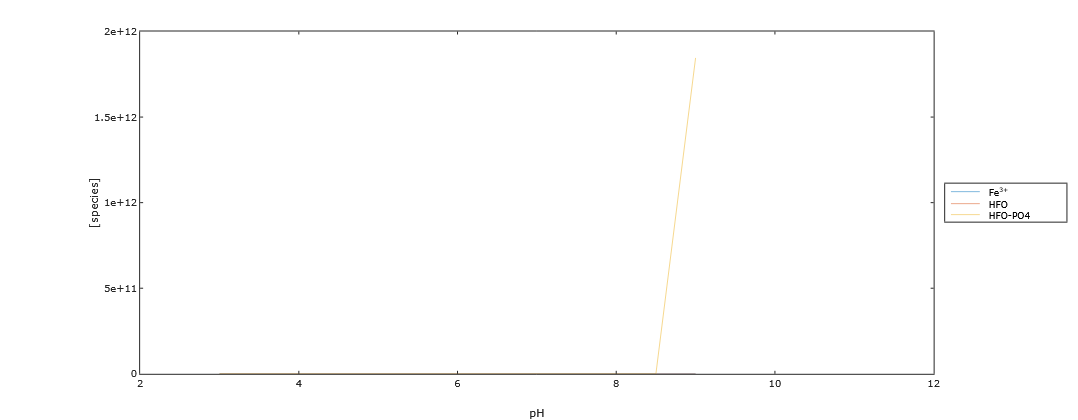

In [4]:
%graphics_toolkit ("notebook"); 
%graphics_toolkit ("gnuplot"); 
%graphics_toolkit ("plotly");

plot(pH,Fep3,pH,HFO,pH,HfowHPO4m)
xlabel('pH'); ylabel('[species]'); legend('Fe^{3+}','HFO','HFO-PO4','location','eastoutside')



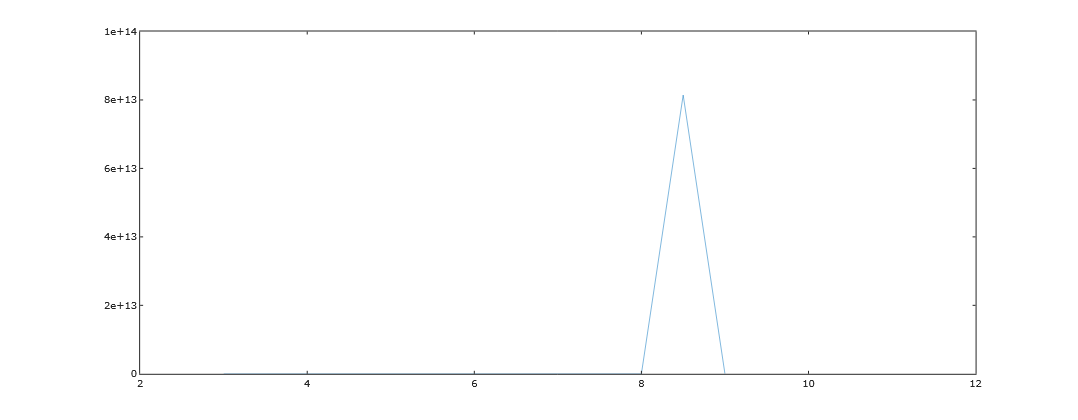

In [5]:
plot(pH,MASSERR)

In [10]:
% 1) crear un archivo de entrada mínimo
fid = fopen('_vercheck.pqi','w');
fputs(fid, "SOLUTION 1\nEND\n");
fclose(fid);

% 2) ejecutar PHREEQC 
system("phreeqc _vercheck.pqi _vercheck.out");

% 3) mostrar la primera línea del .out  
system("sed -n '1p' _vercheck.out");